In [2]:
!pip install labelme tensorflow opencv-python matplotlib albumentations


[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


# 1.2 Collect Images Using OpenCV

In [6]:
import os
import time
import uuid
import cv2
# uuid help us to create unique file name for our images

In [4]:
uuid.uuid1()

UUID('8cb9fe06-d99e-11ed-b255-80b6555d53b2')

In [5]:
IMAGE_PATH=os.path.join('data','images')#this will create separate folder for storing images
number_images=30

In [6]:
for image_num in range(30):
    print(image_num)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


In [7]:
cap=cv2.VideoCapture(0)
for imagnum in range(number_images):
    print("Collecting image {}".format(imagnum))
    ret,frame=cap.read()#this will return a confirmation statement that all is fine and also reutrn the frame of the image
    imgname=os.path.join(IMAGE_PATH,f'{str(uuid.uuid1())}.jpg')
    cv2.imwrite(imgname,frame)
    cv2.imshow('frame',frame)#this statement will show the frames on the screen
    time.sleep(0.5)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break #this if block will break the loop if anything wrong happens
cap.release()
cv2.destroyAllWindows()

1.3 Annotate Images with LabelMe

In [8]:
!labelme


<!--
Now we will perform data preprocessing 
  first:
we gonna look at some collected sample using matplotlib
Then we will split it into training, testing and validation partition.

this is best practice
the model is trained from the training partiion but at the same time we use the validation partition to inform how we built the neural network, so if we say that the model is performing well in training partition but it shaky as hell on the validation set it might mean that we need to try some regularization or change some neural network architecture. 
What about the test set?
we leave it for the end to check how our model will performed, in completely new data.

-->

2.Review our dataset and build Image Loading Function
2.1 Import TF and DEps

In [5]:
import tensorflow as tf
import json
import numpy as np
from matplotlib import pyplot as plt

2.2 Limit GPU Memory Growth

In [10]:
# Avoid OOM errors by setting GPU Memory Consumption Growths
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu,True)

In [11]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


False

2.3 Load Image into TF Data Pipeline

In [12]:

images=tf.data.Dataset.list_files('data\\images\\*.jpg',shuffle=False)

InvalidArgumentError: Expected 'tf.Tensor(False, shape=(), dtype=bool)' to be true. Summarized data: b'No files matched pattern: data\\images\\*.jpg'

In [ ]:
images.as_numpy_iterator().next()

In [1]:
def load_image(x):
    byte_img=tf.io.read_file(x)
    img=tf.io.decode_jpeg(byte_img)
    return img

In [ ]:
images=images.map(load_image)

In [ ]:
images.as_numpy_iterator().next()

In [ ]:
type(images)

2.4 View Raw images with Matplotlib

In [ ]:
image_generator=images.batch(4).as_numpy_iterator()

In [ ]:
plot_images=image_generator.next()#this line will give a next batch of images

In [ ]:
fig,ax=plt.subplots(ncols=4, figsize=(20,20))
for idx, image in enumerate(plot_images):
    ax[idx].imshow(image)
plt.show()

3. Partition Unaugmented Data

3.1 MANUALLY SPLIT DATA INTO TRAIN TEST AND VAL


In [ ]:
90*0.7 # to train/


In [ ]:
90*0.15 #14 and 13 to test and val

3.2 Move the Matching Labels

In [ ]:
#Below code will basically divide the labels of the images into 
# train,test and val folders and labels of the respective images will only 
# be sent to the respective folders

for folder in ['train','test','val']:
    for file in os.listdir(os.path.join('data',folder,'images')):
        filename=file.split('.')[0]+'.json'
        existing_filepath=os.path.join('data','labels',filename)
        if os.path.exists(existing_filepath):
            new_filepath=os.path.join('data', folder, 'labels',filename)
            os.replace(existing_filepath,new_filepath)
            

4. Apply Image Augmentation on Images and Labels using Albumentations

4.1 Setup Albumentation Transform Pipeline


In [2]:
import albumentations as alb

In [3]:
augmentor=alb.Compose([alb.RandomCrop(width=450,height=450),#Cut the images by 450 X 450
                      alb.HorizontalFlip(p=0.5),
                       alb.RandomBrightnessContrast(p=0.2),
                       alb.RandomGamma(p=0.2),
                       alb.RGBShift(p=0.2),
                       alb.VerticalFlip(p=0.5)
                      ],
                      bbox_params=alb.BboxParams(format='albumentations',label_fields=['class_labels']))
                     

4.2 Load a Test Image and Annotation with OpenCv and JSON

In [7]:


img=cv2.imread(os.path.join('data','train','images','3343cb5e-d5ba-11ed-a7dd-80b6555d53b2.jpg'))

In [8]:
img

array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[105,  87,  70],
        [103,  88,  69],
        [105,  90,  71],
        ...,
        [ 93,  95, 103],
        [ 89,  91, 101],
        [ 91,  93, 104]],

       [[107,  87,  69],
        [105,  88,  67],
        [107,  91,  68],
        ...,
        [ 90,  94,  95],
        [ 90,  93,  97],
        [ 88,  91,  95]],

       [[108,  89,  68],
        [107,  89,  66],
        [105,  89,  66],
        ...,
        [ 88,  93,  91],
        [ 89,  94,  93],
        [ 83,  88,  87]]

In [9]:

with open(os.path.join('data','train','labels','3343cb5e-d5ba-11ed-a7dd-80b6555d53b2.json'),'r') as f:
    label=json.load(f)

In [10]:
label['shapes'][0]['points']

[[219.47089947089947, 100.58201058201058],
 [436.40211640211646, 401.1111111111111]]

4.3 Extract Coordinates and Rescale to Match Image Resolution

In [11]:
coords=[0,0,0,0]
coords[0]=label['shapes'][0]['points'][0][0]
coords[1]=label['shapes'][0]['points'][0][1]
coords[2]=label['shapes'][0]['points'][1][0]
coords[3]=label['shapes'][0]['points'][1][1]

In [12]:
coords

[219.47089947089947, 100.58201058201058, 436.40211640211646, 401.1111111111111]

In [13]:
# here we will convert pascal_voc format to albumentation
# by dividing the each value coords by width and hight given[640,480,640,480]
coords=list(np.divide(coords,[640,480,640,480]))

In [14]:
coords

[0.3429232804232804, 0.2095458553791887, 0.681878306878307, 0.8356481481481481]

4.4 Apply Augmentation and View Results

In [15]:
augmented=augmentor(image=img, bboxes=[coords],class_labels=['face'])

In [16]:
augmented

{'image': array([[[173, 142,  97],
         [172, 143,  98],
         [172, 143,  98],
         ...,
         [217, 157, 151],
         [213, 154, 144],
         [212, 153, 138]],
 
        [[170, 141,  96],
         [172, 143,  98],
         [173, 144,  99],
         ...,
         [220, 159, 155],
         [216, 157, 148],
         [215, 155, 143]],
 
        [[172, 143,  99],
         [172, 143,  99],
         [170, 144,  98],
         ...,
         [222, 161, 159],
         [218, 158, 152],
         [218, 157, 147]],
 
        ...,
 
        [[175, 153, 112],
         [158, 132,  95],
         [137, 111,  74],
         ...,
         [117, 107, 100],
         [104,  95,  92],
         [ 96,  90,  91]],
 
        [[169, 149, 108],
         [150, 127,  89],
         [132, 109,  71],
         ...,
         [129, 118, 110],
         [116, 105, 101],
         [102,  94,  94]],
 
        [[168, 148, 107],
         [146, 125,  87],
         [132, 109,  71],
         ...,
         [138, 126,

In [21]:
augmented['bboxes']#[xmin,ymin,xmax,ymax]

[(0.4832686654908877,
  0.16351557907113462,
  0.9653380364491477,
  0.831358024691358)]

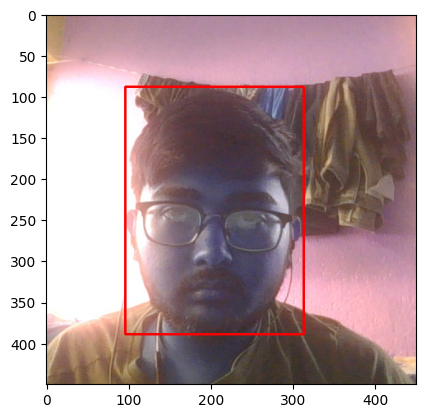

In [17]:
cv2.rectangle(augmented['image'],
              tuple(np.multiply(augmented['bboxes'][0][:2],[450,450]).astype(int)),#top two coordinates
             tuple(np.multiply(augmented['bboxes'][0][2:],[450,450]).astype(int)),#bottom two coordinates
              (250,0,0),2)#(250,0,0)  BGR # 2 ==>thickeness of rectangle

plt.imshow(augmented['image'])
# open cv===BGR
# MATPLOTLIB===RGB

5. Build and Run Augmentation Pipeline
5.1 Run Augmentation Pipeline

In [ ]:
for partition in ['train','test','val']:
    for image in os.listdir(os.path.join('data',partition,'images')):
        img=cv2.imread(os.path.join('data',partition,'images',image))
        
        coords=[0,0,0.00001,0.00001]
        label_path=os.path.join('data',partition,'labels',f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):
            with open(label_path,'r') as f:
                label=json.load(f)
            coords[0]=label['shapes'][0]['points'][0][0]
            coords[1]=label['shapes'][0]['points'][0][1]
            coords[2]=label['shapes'][0]['points'][1][0]            
            coords[3]=label['shapes'][0]['points'][1][1]
            coords=list(np.divide(coords,[640,480,640,480]))
            
        try:
            for x in range(60):
                augmented=augmentor(image=img,bboxes=[coords], class_labels=['face'])
                cv2.imwrite(os.path.join('aug_data',partition,'images',f'{image.split(".")[0]}.{x}.jpg'),augmented['image'])
                annotation={}
                annotation['image']=image
                if os.path.exists(label_path):
                    if len(augmented['bboxes'])==0:
                        annotation['bbox']=[0,0,0,0]
                        annotation['class']=0
                    else:
                        annotation['bbox']=augmented['bboxes'][0]
                        annotation['class']=1
                else:
                    annotation['bbox']=[0,0,0,0]
                    annotation['class']=0
                with open(os.path.join('aug_data',partition,'labels',f'{image.split(".")[0]}.{x}.json'),'w') as f:
                    json.dump(annotation,f)
        except Exception as e:
            print(e,"&&&&")

5.2 Load Augmented Images to Tensorflow Dataset

In [18]:
train_images=tf.data.Dataset.list_files('aug_data\\train\\images\\*.jpg',shuffle=False)
train_images=train_images.map(load_image)
train_images=train_images.map(lambda x: tf.image.resize(x,(120,120)))# resizing is done to compress the image suitable for neural network
train_images=train_images.map(lambda x:x/255)# division is done to bring the output between 0 and 1 so that at output layer we can implement sigmoid function


In [19]:
test_images=tf.data.Dataset.list_files('aug_data\\test\\images\\*.jpg',shuffle=False)
test_images=test_images.map(load_image)
test_images=test_images.map(lambda x: tf.image.resize(x,(120,120)))# resizing is done to compress the image suitable for more efficient neural network
test_images=test_images.map(lambda x:x/255)# division is done to bring the output between 0 and 1 so that at output layer we can implement sigmoid function


In [20]:
val_images=tf.data.Dataset.list_files('aug_data\\val\\images\\*.jpg',shuffle=False)
val_images=val_images.map(load_image)
val_images=val_images.map(lambda x: tf.image.resize(x,(120,120)))# resizing is done to compress the image suitable for neural network
val_images=val_images.map(lambda x:x/255)# division is done to bring the output between 0 and 1 so that at output layer we can implement sigmoid function


In [21]:
train_images.as_numpy_iterator().next()

array([[[0.61715686, 0.6014706 , 0.8014706 ],
        [0.6248162 , 0.6003064 , 0.78903186],
        [0.62628675, 0.5909926 , 0.7674632 ],
        ...,
        [0.39987746, 0.57634807, 0.7057598 ],
        [0.39675245, 0.5653799 , 0.7008578 ],
        [0.40661764, 0.58370095, 0.714951  ]],

       [[0.62941176, 0.6093137 , 0.81078434],
        [0.6305147 , 0.59957105, 0.79859066],
        [0.627451  , 0.5921569 , 0.7764706 ],
        ...,
        [0.39466912, 0.5711397 , 0.6995711 ],
        [0.40085784, 0.5764706 , 0.699326  ],
        [0.4216299 , 0.5941789 , 0.71770835]],

       [[0.6372549 , 0.6215686 , 0.8215686 ],
        [0.6348652 , 0.606924  , 0.8059436 ],
        [0.6284314 , 0.59313726, 0.777451  ],
        ...,
        [0.39454657, 0.5788603 , 0.69650733],
        [0.41764706, 0.60183823, 0.71954656],
        [0.39883578, 0.5909926 , 0.7086397 ]],

       ...,

       [[0.45637256, 0.56507355, 0.6050858 ],
        [0.4237745 , 0.5296569 , 0.55710787],
        [0.31599265, 0

6. Prepare Labels

6.1 Build Label Loading Function


In [21]:
def load_labels(label_path):
    with open(label_path.numpy(),'r',encoding="utf-8") as f:
        label=json.load(f)
    return [label['class']], label['bbox']

In [22]:
train_labels=tf.data.Dataset.list_files('aug_data\\train\\labels\\*.json',shuffle=False)
train_labels=train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8,tf.float16]))


In [23]:
test_labels=tf.data.Dataset.list_files('aug_data\\test\\labels\\*.json',shuffle=False)
test_labels=test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8,tf.float16]))


In [24]:
val_labels=tf.data.Dataset.list_files('aug_data\\val\\labels\\*.json',shuffle=False)
val_labels=val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8,tf.float16]))


In [26]:
train_labels.as_numpy_iterator().next()

(array([1], dtype=uint8),
 array([0.2769, 0.1946, 0.759 , 0.8623], dtype=float16))

7. Combine Label AND Image Samples

 7.1 Check Partition Lengths

In [25]:
len(train_images),len(train_labels),len(test_images),len(test_labels),len(val_images),len(val_labels)

(3720, 3720, 840, 840, 780, 780)

7.2 Create Final Datasets(Images/Labels)


In [26]:
train=tf.data.Dataset.zip((train_images,train_labels))
# this command will zip the train_images dataset with the train_labebl
# len of train_images==120--> It consists of utf format of whole image
# len of train_labels==1--> it consists of only the labels of the box
train=train.shuffle(5000)#idealy we want that the size of shuffle buffer must be biger than the dataset ie, 3720 here
train=train.batch(8)#Batch it up .....8 images and 8 labels
train=train.prefetch(4)#this hellps to eliminate bottlenecks while we load and train data

In [27]:
test=tf.data.Dataset.zip((test_images,test_labels))
# this command will zip the train_images dataset with the train_labebl
# len of train_images==120--> It consists of utf format of whole image
# len of train_labels==1--> it consists of only the labels of the box
test=test.shuffle(1300)#idealy we want that the size of shuffle buffer must be biger than the dataset ie, 3720 here
test=test.batch(8)#Batch it up .....8 images and 8 labels
test=test.prefetch(4)#this hellps to eliminate bottlenecks while we load and train data

In [28]:
val=tf.data.Dataset.zip((val_images,val_labels))
# this command will zip the val_images dataset with the val_labebl
# len of val_images==120--> It consists of utf format of whole image
# len of val_labels==1--> it consists of only the labels of the box
val=val.shuffle(1000)#idealy we want that the size of shuffle buffer must be biger than the dataset ie, 3720 here
val=val.batch(8)#Batch it up .....8 images and 8 labels
val=val.prefetch(4)#this hellps to eliminate bottlenecks while we load and train data

In [29]:
train.as_numpy_iterator().next()[0].shape
# 8 --> images
# 120 --> high
# 120 --> wide
# 3 --> tunnels(as it is colord images)

(8, 120, 120, 3)

7.3 View Images and Annotations

In [30]:
data_samples=train.as_numpy_iterator()

In [31]:
res=data_samples.next()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


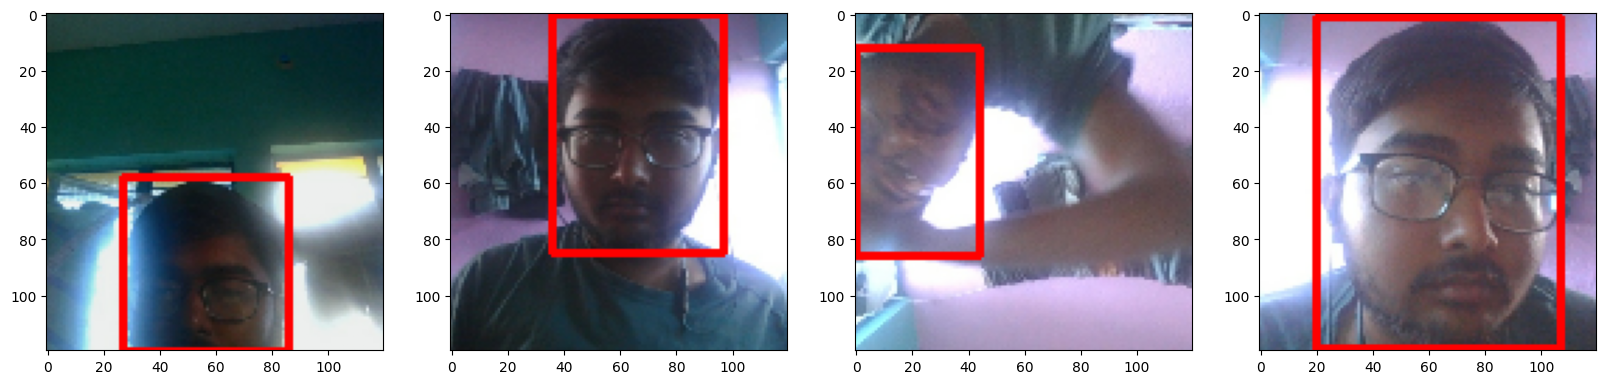

In [32]:
fig, ax=plt.subplots(ncols=4,figsize=(20,20))
for idx in range(4):
    sample_image=res[0][idx]
    sample_coords=res[1][1][idx]
    cv2.rectangle(sample_image,
                 tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                 tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)),
                 (250,0,0),2)
    ax[idx].imshow(sample_image)

8. Building Deep Learning using the Functional API

8.1 Import Layers and Base Network

In [33]:
from tensorflow.keras.models import Model #Base of the model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16


8.2 Download VGG16

In [35]:
vgg=VGG16(include_top=False)

In [36]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

8.3 Build Instance of Network

In [37]:
def build_model():
    input_layer=Input(shape=(120,120,3))# shape of the input images
    vgg=VGG16(include_top=False)(input_layer)#include_top=False because we want to drop the final layers
#     Classification Model
    f1= GlobalMaxPooling2D()(vgg)#taking only the maximum value
    # print(type(f1))
    class1=Dense(2048,activation='relu')(f1)
    # print(type(class1))
    class2=Dense(1,activation='sigmoid')(class1)# having 1 output because it maps down only classification
    
#     Bounding box model
    f2=GlobalMaxPooling2D()(vgg)
    regress1=Dense(2048,activation='relu')(f2)
    regress2=Dense(4,activation='sigmoid')(regress1)# having 4 units because labels have 4 coordinates
    
    facetracker=Model(inputs=input_layer, outputs=[class2, regress2])#combine bothe using Model API
    return facetracker
    

In [38]:
train.as_numpy_iterator().next()[1]# this is the output

(array([[0],
        [1],
        [0],
        [1],
        [1],
        [1],
        [1],
        [1]], dtype=uint8),
 array([[0.     , 0.     , 0.     , 0.     ],
        [0.3    , 0.1626 , 0.799  , 0.819  ],
        [0.     , 0.     , 0.     , 0.     ],
        [0.     , 0.08044, 0.3975 , 0.6753 ],
        [0.1365 , 0.01904, 0.8633 , 1.     ],
        [0.607  , 0.133  , 1.     , 0.821  ],
        [0.178  , 0.1985 , 0.6704 , 0.87   ],
        [0.11   , 0.     , 0.6284 , 0.6064 ]], dtype=float16))

8.4 Test out Neural Network


In [39]:
facetracker=build_model()

In [40]:
facetracker.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 120, 120, 3  0           []                               
                                )]                                                                
                                                                                                  
 vgg16 (Functional)             (None, None, None,   14714688    ['input_2[0][0]']                
                                512)                                                              
                                                                                                  
 global_max_pooling2d (GlobalMa  (None, 512)         0           ['vgg16[0][0]']                  
 xPooling2D)                                                                                  

In [41]:
X,y=train.as_numpy_iterator().next()

In [42]:
X.shape


(8, 120, 120, 3)

In [43]:
classes,coords=facetracker.predict(X)

1/1 [==============================] - 2s 2s/step


In [44]:
classes, coords

(array([[0.5542476 ],
        [0.5424962 ],
        [0.5085863 ],
        [0.5121208 ],
        [0.61719674],
        [0.5590795 ],
        [0.56450635],
        [0.63627326]], dtype=float32),
 array([[0.65528923, 0.5814944 , 0.4135703 , 0.51607037],
        [0.6229734 , 0.677749  , 0.41148207, 0.44818312],
        [0.62214524, 0.65938   , 0.45586726, 0.4532297 ],
        [0.61809427, 0.56430215, 0.43945643, 0.43888506],
        [0.5564924 , 0.64990765, 0.42453903, 0.49317127],
        [0.6052157 , 0.61040765, 0.40419596, 0.4449981 ],
        [0.63084155, 0.6032075 , 0.42318335, 0.38729942],
        [0.6756645 , 0.6579438 , 0.3609356 , 0.4411104 ]], dtype=float32))

9. Define Losses and Optimizers

9.1 Define Optimizer and LR

In [46]:
len(train)

465

In [47]:
batches_per_epoch=len(train)
lr_decay=(1./0.75-1)/batches_per_epoch


In [48]:
lr_decay

0.0007168458781362006

In [49]:
opt=tf.keras.optimizers.legacy.Adam(learning_rate=0.0001, decay=lr_decay)

9.2 Create Localization Loss and Classification Loss

In [50]:
def localization_loss(y_true, yhat):
    
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))
        
#     y_true contains the actual coordinates
#     y_hat contains the predicted coordinates
    h_true = y_true[:,3] - y_true[:,1] 
    w_true = y_true[:,2] - y_true[:,0] 

    h_pred = yhat[:,3] - yhat[:,1] 
    w_pred = yhat[:,2] - yhat[:,0] 
    
    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true-h_pred))
    
    return delta_coord + delta_size



'''
This function return the localization loss that is difference between actual value and the 
predicted value of the label coordinate and the presence of face 
'''

'\nThis function return the localization loss that is difference between actual value and the \npredicted value of the label coordinate and the presence of face \n'

In [51]:
classloss=tf.keras.losses.BinaryCrossentropy()
regressloss=localization_loss

9.3 Test out Loss Metrics 


In [52]:
localization_loss(y[1],coords).numpy()


10.151543

In [53]:
classloss(y[0],classes)

<tf.Tensor: shape=(), dtype=float32, numpy=0.57937413>

In [56]:
regressloss(y[1],coords)

<tf.Tensor: shape=(), dtype=float32, numpy=3.955132>

10. Train Neural Network

10.1 Create Custom Model Class

In [54]:
class FaceTracker(Model): 
    def __init__(self, eyetracker,  **kwargs): 
        super().__init__(**kwargs)
        self.model = eyetracker# this is actually the facetrack model

    def compile(self, opt, classloss, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.closs = classloss
        self.lloss = localizationloss
        self.opt = opt
    
    def train_step(self, batch, **kwargs): # this step actually trains our neural network # model.fit() will trigger this step
        
        X, y = batch #X=images, y=actual class and label values
        
        with tf.GradientTape() as tape: #this line actualy works like a trigger which tells thay tensorflow is keeping a note for every operation which will be helpful in further for backpropogation
            classes, coords = self.model(X, training=True)# here self.model is just like calling facetracker model over X values
#             classes and coords are the predicted values given by facetrack model
            
            batch_classloss = self.closs(y[0], classes)#here we are passing the actuel class values and the predected class values to determine the class loss
            batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)##here we are passing the actuel coords values and the predected coord values to determine the localization loss
            
            total_loss = batch_localizationloss+0.5*batch_classloss
            
            grad = tape.gradient(total_loss, self.model.trainable_variables)# here we are calculating the gradience
        
        opt.apply_gradients(zip(grad, self.model.trainable_variables))# gradient descent along with trainable variables using a partibular optimizer helps in improving our neural network while back propogation
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
    
    def test_step(self, batch, **kwargs): # this functinon is triggered as soon as validation dataset is passed
        X, y = batch
        classes, coords = self.model(X, training=False)
        
        batch_classloss = self.closs(y[0], classes)#closs==>classification loss
        batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)#lloss==>localizationation loss
        total_loss = batch_localizationloss+0.5*batch_classloss
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
        
    def call(self, X, **kwargs): #this function is comes into play when we use model.predict()
        return self.model(X, **kwargs)

In [55]:
model = FaceTracker(facetracker)

In [56]:
model.compile(opt, classloss, regressloss)


10.2 Train

In [57]:
logdir='logs'

In [58]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)


In [59]:
hist = model.fit(train, epochs=10, validation_data=val, callbacks=[tensorboard_callback])
 

Epoch 1/10
465/465 [==============================] - 1248s 3s/step - total_loss: 0.2809 - class_loss: 0.0575 - regress_loss: 0.2521 - val_total_loss: 0.0164 - val_class_loss: 7.0632e-06 - val_regress_loss: 0.0164
Epoch 2/10
465/465 [==============================] - 998s 2s/step - total_loss: 0.0679 - class_loss: 0.0152 - regress_loss: 0.0603 - val_total_loss: 0.2904 - val_class_loss: 0.2523 - val_regress_loss: 0.1643
Epoch 3/10
465/465 [==============================] - 927s 2s/step - total_loss: 0.0260 - class_loss: 0.0062 - regress_loss: 0.0229 - val_total_loss: 0.0111 - val_class_loss: 1.9357e-05 - val_regress_loss: 0.0111
Epoch 4/10
465/465 [==============================] - 994s 2s/step - total_loss: 0.0496 - class_loss: 0.0122 - regress_loss: 0.0435 - val_total_loss: 0.0111 - val_class_loss: 1.4513e-04 - val_regress_loss: 0.0110
Epoch 5/10
465/465 [==============================] - 993s 2s/step - total_loss: 0.0232 - class_loss: 0.0047 - regress_loss: 0.0208 - val_total_loss: 0

10.3 Plot Performance

In [60]:
hist.history

{'total_loss': [0.07016750425100327,
  0.020552946254611015,
  0.013403392396867275,
  0.01584382727742195,
  0.01338326558470726,
  0.00697850389406085,
  0.010080128908157349,
  0.008768845349550247,
  0.00788537785410881,
  0.0035610701888799667],
 'class_loss': [0.0002071044873446226,
  0.0012603115756064653,
  0.0006068634102120996,
  0.00010747890337370336,
  9.857149416347966e-05,
  2.2352625819621608e-05,
  0.0006104747881181538,
  7.748683856334537e-06,
  3.336665395181626e-05,
  1.6578267604927532e-05],
 'regress_loss': [0.07006394863128662,
  0.019922791048884392,
  0.01309996098279953,
  0.01579008810222149,
  0.013333979994058609,
  0.006967327557504177,
  0.009774891659617424,
  0.008764971047639847,
  0.007868694141507149,
  0.0035527809523046017],
 'val_total_loss': [0.01643489859998226,
  0.2904186248779297,
  0.011094043962657452,
  0.011066656559705734,
  0.01226745080202818,
  1.3765754699707031,
  0.23728124797344208,
  0.022012196481227875,
  0.5723662376403809,
 

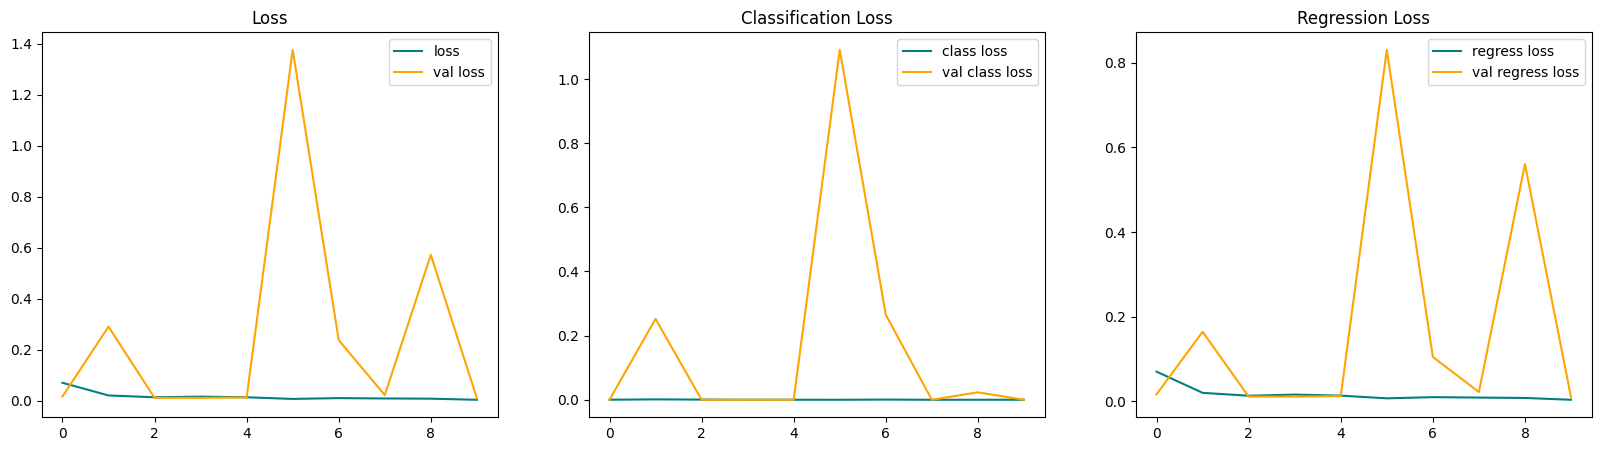

In [61]:
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist.history['total_loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_total_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['class_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_class_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

ax[2].plot(hist.history['regress_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_regress_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Regression Loss')
ax[2].legend()

plt.show()

11. Make Prediction

11.1 Make Predictions on Test Set

In [62]:
test_data = test.as_numpy_iterator()


In [68]:
test_sample = test_data.next()


In [69]:
yhat = facetracker.predict(test_sample[0])

1/1 [==============================] - 0s 305ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


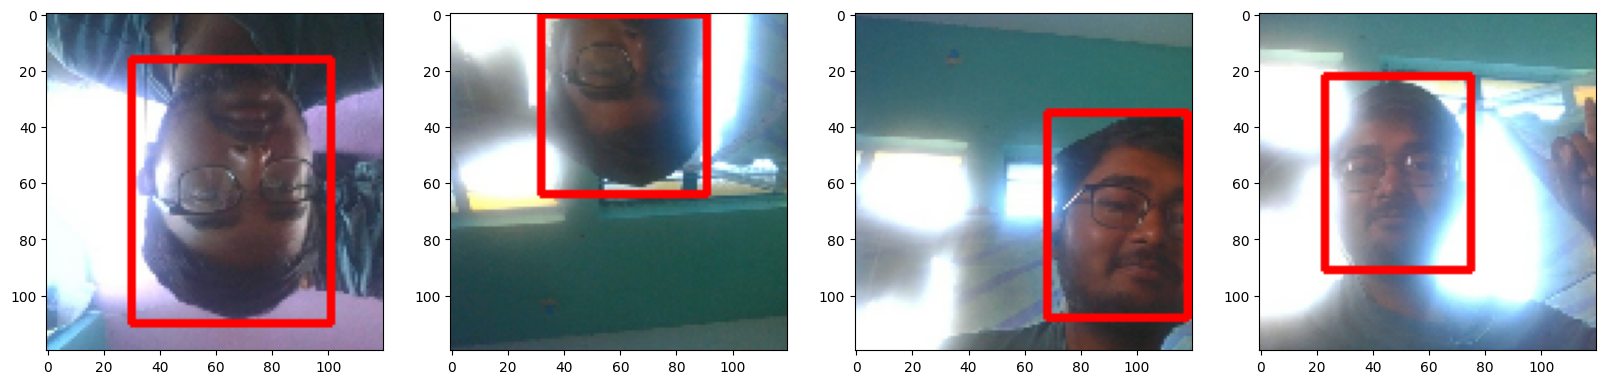

In [70]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = test_sample[0][idx]
    sample_coords = yhat[1][idx]
    
    if yhat[0][idx] > 0.9:
        cv2.rectangle(sample_image, 
                      tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                            (255,0,0), 2)
    
    ax[idx].imshow(sample_image)

11.2 Save the Model

In [71]:
from tensorflow.keras.models import load_model

In [72]:
facetracker.save('facetracker.h5')

In [73]:
facetracker = load_model('facetracker.h5')

11.3 Real Time Detection


In [76]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    _ , frame = cap.read()
    frame = frame[50:500, 50:500,:]
    
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = tf.image.resize(rgb, (120,120))
    
    yhat = facetracker.predict(np.expand_dims(resized/255,0))
    sample_coords = yhat[1][0]
    
    if yhat[0] > 0.5: 
        # Controls the main rectangle
        cv2.rectangle(frame, 
                      tuple(np.multiply(sample_coords[:2], [450,450]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [450,450]).astype(int)), 
                            (255,0,0), 2)
        # Controls the label rectangle
        cv2.rectangle(frame, 
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int), 
                                    [0,-30])),
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                    [80,0])), 
                            (255,0,0), -1)
        
        # Controls the text rendered
        cv2.putText(frame, 'face', tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                               [0,-5])),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
    
    cv2.imshow('EyeTrack', frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 75ms/step
